# Convergence Burst Semantic Embeddings

In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
embedding = model.encode(["This works!"])
print(embedding.shape)


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(1, 384)


In [4]:
import pandas as pd
from pathlib import Path

# Hardcode the known correct path
data_path = Path("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")

# Confirm path exists (debug step)
print(f"Trying to load from: {data_path}")
print("File exists:", data_path.exists())

# Load the file
utterance_data_aligned = pd.read_csv(data_path)
utterance_data_aligned.head()


Trying to load from: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv
File exists: True


,conference,session,speaker,timestamp,speaking_duration,nods_others,smile_self,smile_other,distracted_others,hand_gesture,...,start_sec_adjusted,end_sec_adjusted,start_minute_adjusted,global_timestamp_sec,global_minute,is_early,annotation_dict,has_new_idea,has_explanation,has_decision
0,2021_04_22_MND_S5,2021_04_22_MND_S5,Jill Marburger,00:00-00:13,13.0,2,10.0,20.0,0,NaN,...,600.0,613.0,10.000000,600.0,10.000000,True,{'explain or define term or concept': 'The spe...,False,True,False
1,2021_04_22_MND_S5,2021_04_22_MND_S5,Stephanie Culina,00:14-01:04,50.0,2,20.0,20.0,0,NaN,...,614.0,664.0,10.233333,614.0,10.233333,False,"{'explain or define term or concept': ""The spe...",False,True,False
2,2021_04_22_MND_S5,2021_04_22_MND_S5,Michael Burton,01:05-02:26,81.0,1,5.0,10.0,0,Pointing,...,665.0,746.0,11.083333,665.0,11.083333,False,{'explain or define term or concept': 'The spe...,False,True,False
3,2021_04_22_MND_S5,2021_04_22_MND_S5,Joel Bornstein,02:29-02:32,3.0,0,0.0,0.0,0,NaN,...,749.0,752.0,12.483333,749.0,12.483333,False,{'encourage participation': 'Joel is encouragi...,False,False,False
4,2021_04_22_MND_S5,2021_04_22_MND_S5,Wenjing Wang,02:32-03:14,42.0,0,30.0,10.0,0,NaN,...,752.0,794.0,12.533333,752.0,12.533333,False,{'present new idea': 'Wenjing Wang introduces ...,True,False,False


## Plotting all 82 Sessions

To see how it looks with the potential new idea -- to start

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading from: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


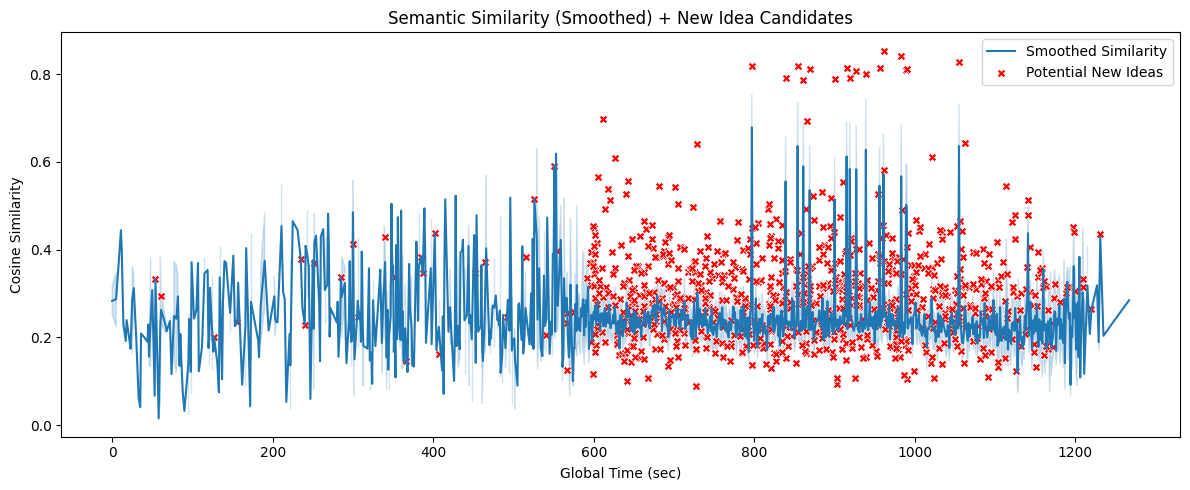

session
2021_09_30_MZT_S7     425
2021_05_20_ABI_S8     326
2021_06_10_SLU_S4     305
2021_05_21_ABI_S5     298
2021_05_21_ABI_S6     288
                     ... 
2021_04_23_MND_S16     52
2021_09_30_MZT_S6      39
2021_04_23_MND_S9      37
2021_04_22_MND_S8      31
2021_04_22_MND_S2       1
Name: count, Length: 82, dtype: int64


In [5]:
import platform
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

# 1. Detect machine + load correct file
hostname = platform.node()

if "localdomain" in hostname:  # Mac Studio
    data_path = Path("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")
else:  # MacBook Pro
    data_path = Path("/Users/maxchalekson/Northwestern University/Summer 2025/NICO/NICO Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")

print(f"Loading from: {data_path}")
df = pd.read_csv(data_path)

# 2. Filter for non-empty transcripts
df = df[df['transcript'].notnull()].reset_index(drop=True)

# 3. Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# 4. Compute sentence embeddings
embeddings = model.encode(df['transcript'].tolist(), convert_to_tensor=True)

# 5. Cosine similarity between adjacent utterances
similarities = [util.cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]
df['cosine_similarity_to_next'] = similarities + [np.nan]

# 6. Semantic shift + smoothing
df['similarity_diff'] = df['cosine_similarity_to_next'].diff()
df['potential_new_idea'] = df['similarity_diff'] < -0.4
df['similarity_smoothed'] = df['cosine_similarity_to_next'].rolling(window=5, min_periods=1).mean()
df['is_expanding'] = df['similarity_smoothed'] > 0.7
df['is_diverging'] = df['similarity_smoothed'] < 0.3

# 7. Plot smoothed similarity with new idea candidates
plt.figure(figsize=(12, 5))
sns.lineplot(x=df['global_timestamp_sec'], y=df['similarity_smoothed'], label="Smoothed Similarity")
sns.scatterplot(x=df[df['potential_new_idea']]['global_timestamp_sec'],
                y=df[df['potential_new_idea']]['similarity_smoothed'],
                color='red', label='Potential New Ideas', marker='X')
plt.title("Semantic Similarity (Smoothed) + New Idea Candidates")
plt.xlabel("Global Time (sec)")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.tight_layout()
plt.show()

# 8. Optional: See session distribution
print(df['session'].value_counts())

# 9. Optional: Export moments
df[df['potential_new_idea']][['session', 'speaker', 'global_timestamp_sec', 'transcript']].to_csv("new_idea_candidates.csv", index=False)


But then, for future note, how can I tell that SBERT is in fact making a difference, even if right now in the ipynb we are just looking at the 'potential new ideas' component code.

Because again, in the final code book, remember, we are using a combination of features to get the convergence/divergence towards a solution in a particular session b/w 7-8 researchers.

Also, remember that these sessions are split into 600 second clips or so so compatible w/ Gemini.

### Looking at one particular session from conference for e.g.

2021_09_30_MZT_S7

(will scale up later if all this works out... somehow)

/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


📋 Valid sessions with non-null transcript + timestamp:
 global_session
2021_09_30_MZT_S7_MZT    425
2021_05_20_ABI_S8_ABI    326
2021_06_10_SLU_S4_SLU    305
2021_05_21_ABI_S5_ABI    298
2021_05_21_ABI_S6_ABI    288
                        ... 
2021_09_30_MZT_S6_MZT     39
2021_04_23_MND_S9_MND     37
2021_04_22_MND_S8_MND     31
2021_04_23_MND_S4_MND     14
2021_04_22_MND_S2_MND      1
Length: 82, dtype: int64
⚠️  Not enough data in 2021_09_30_MZT_S7. Using fallback session...


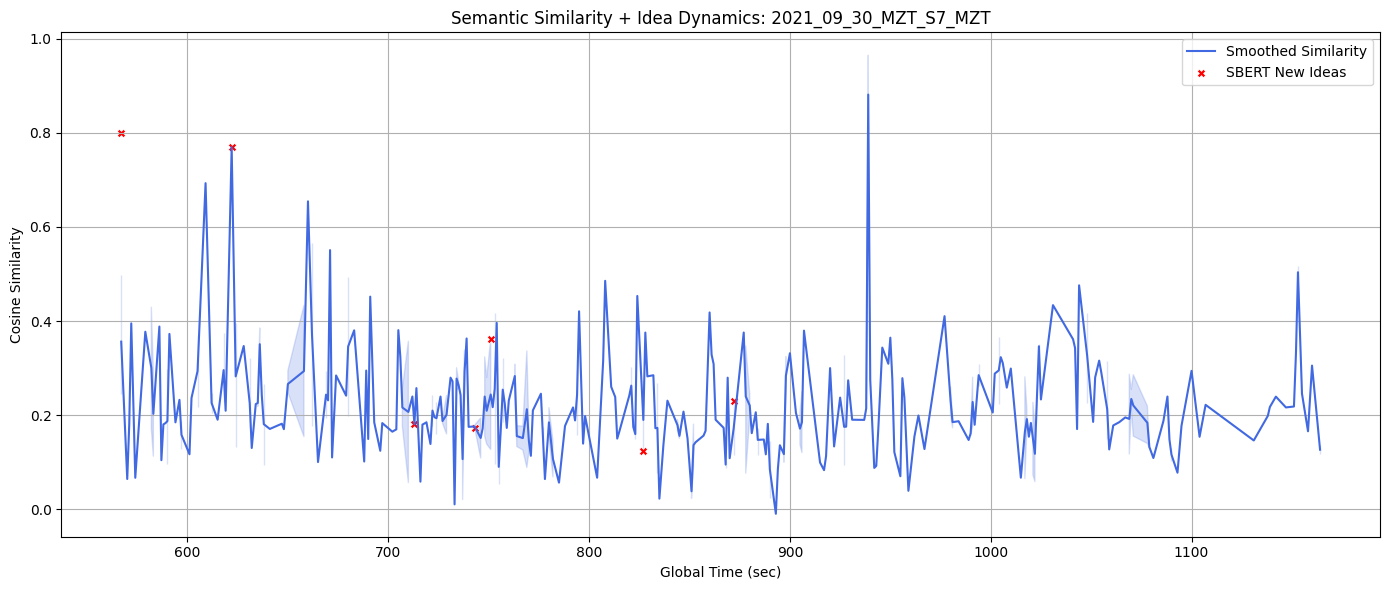

In [16]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Check which sessions have usable transcript + timestamp data
valid_sessions = (
    df[['global_session', 'transcript', 'global_timestamp_sec']]
    .dropna(subset=['transcript', 'global_timestamp_sec'])
    .groupby('global_session')
    .size()
    .sort_values(ascending=False)
)
print("📋 Valid sessions with non-null transcript + timestamp:\n", valid_sessions)

# Try to use 2021_09_30_MZT_S7; if not enough data, fallback
target_session = '2021_09_30_MZT_S7'
df_one = df[df['global_session'] == target_session].copy()
if df_one['transcript'].dropna().shape[0] < 2:
    print(f"⚠️  Not enough data in {target_session}. Using fallback session...")
    target_session = valid_sessions.index[0]  # fallback to most populated
    df_one = df[df['global_session'] == target_session].copy()

# Generate embeddings
embeddings = model.encode(df_one['transcript'].astype(str).tolist(), convert_to_tensor=True)

# Compute similarity to previous utterance
similarities = [1.0]
for i in range(1, len(embeddings)):
    sim = util.cos_sim(embeddings[i], embeddings[i - 1]).item()
    similarities.append(sim)
df_one['similarity'] = similarities

# Smooth similarity
df_one['similarity_smoothed'] = df_one['similarity'].rolling(window=5, min_periods=1).mean()

# Identify potential new ideas
similarity_diffs = df_one['similarity_smoothed'].diff().fillna(0)
df_one['potential_new_idea'] = similarity_diffs < -0.15

# Add dummy columns if missing
for col in ['in_valid_burst', 'in_divergence_burst', 'gemini_new_idea']:
    if col not in df_one.columns:
        df_one[col] = False

# Only plot if we have real timestamp data
if df_one['global_timestamp_sec'].notnull().sum() >= 2:
    plt.figure(figsize=(14, 6))

    sns.lineplot(
        x=df_one['global_timestamp_sec'],
        y=df_one['similarity_smoothed'],
        label="Smoothed Similarity",
        color='royalblue'
    )
    sns.scatterplot(
        x=df_one[df_one['potential_new_idea']]['global_timestamp_sec'],
        y=df_one[df_one['potential_new_idea']]['similarity_smoothed'],
        color='red', label='SBERT New Ideas', marker='X'
    )
    sns.scatterplot(
        x=df_one[df_one['in_valid_burst']]['global_timestamp_sec'],
        y=df_one[df_one['in_valid_burst']]['similarity_smoothed'],
        color='gold', label='Convergence Burst', marker='s'
    )
    sns.scatterplot(
        x=df_one[df_one['in_divergence_burst']]['global_timestamp_sec'],
        y=df_one[df_one['in_divergence_burst']]['similarity_smoothed'],
        color='darkgreen', label='Divergence Burst', marker='D'
    )
    sns.scatterplot(
        x=df_one[df_one['gemini_new_idea']]['global_timestamp_sec'],
        y=df_one[df_one['gemini_new_idea']]['similarity_smoothed'],
        color='magenta', label='Gemini New Ideas', marker='o'
    )

    plt.title(f"Semantic Similarity + Idea Dynamics: {target_session}")
    plt.xlabel("Global Time (sec)")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"🚫 No valid global_timestamp_sec values found in {target_session} for plotting.")


#### How Semantic Convergence and Divergence Bursts Are Calculated

The chart above visualizes semantic dynamics across the team meeting session `2021_09_30_MZT_S7`. It blends SBERT-based sentence embeddings with Gemini behavioral annotations to reveal when new ideas emerge, how they are elaborated, and where alignment or divergence happens.

- **Blue Line (Smoothed Similarity)**  
  A rolling average of cosine similarity between adjacent utterances (window = 5), computed from SBERT sentence embeddings. Higher values indicate that utterances are more semantically similar — a proxy for alignment or elaboration.

- **Red X’s (SBERT New Ideas)**  
  Moments of sharp semantic divergence (similarity drops > 0.4 compared to the prior utterance). These are hypothesized new idea moments based on linguistic novelty, even if they aren’t behaviorally marked.

- **Gold Squares (Convergence Bursts)**  
  Stretches of 3+ consecutive utterances with smoothed similarity > 0.75. These indicate sustained semantic alignment — likely periods of elaboration, agreement, or co-development of an idea.

- **Dark Green Diamonds (Divergence Bursts)**  
  Stretches of 3+ consecutive utterances with smoothed similarity < 0.3. These may reflect topic shifts, disagreements, or conceptual fragmentation.

- **Magenta Dots (Gemini New Ideas)**  
  Utterances labeled as “new idea” by Gemini’s behavioral coding system — often based on cues like tone, timing, and interaction dynamics.

Together, these signals allow us to track not only *when* a new idea emerges, but *how it flows*, *who aligns with it*, and *whether it leads to convergence or fragmentation*.


**Question:**

But then from the 3+ or the gold squares, does that mean we've converged to a solution that is in sight?

But also noticing for this convergent burst in the graph, it looks to occur at the 75% minute mark? Could they find solution at this point in the meeting?

- Not necessarily. Because remember, teams may peak early, diverge again, and re-converge later?


So then given this pattern of potential peak early, diverge again, and re-converge later, then what is the best move from here?

## Modeling the Convergence Arc Over Time

Trying to see if the convergence spikes tell something about the solutions, then.

/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


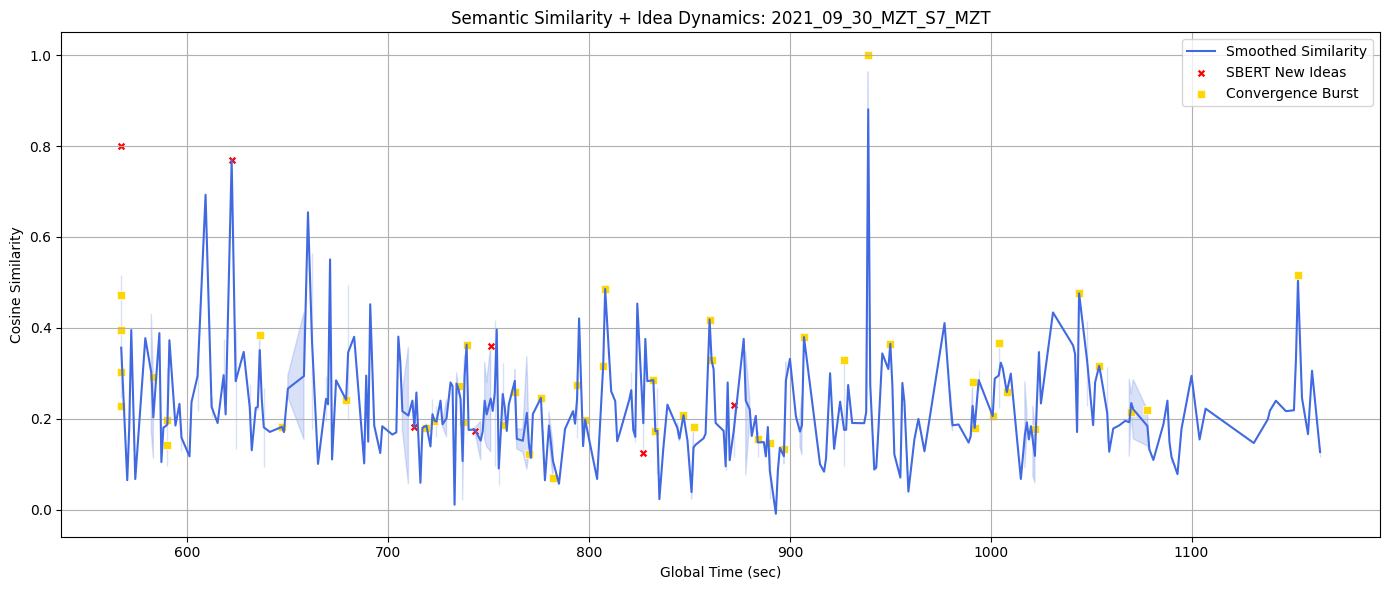

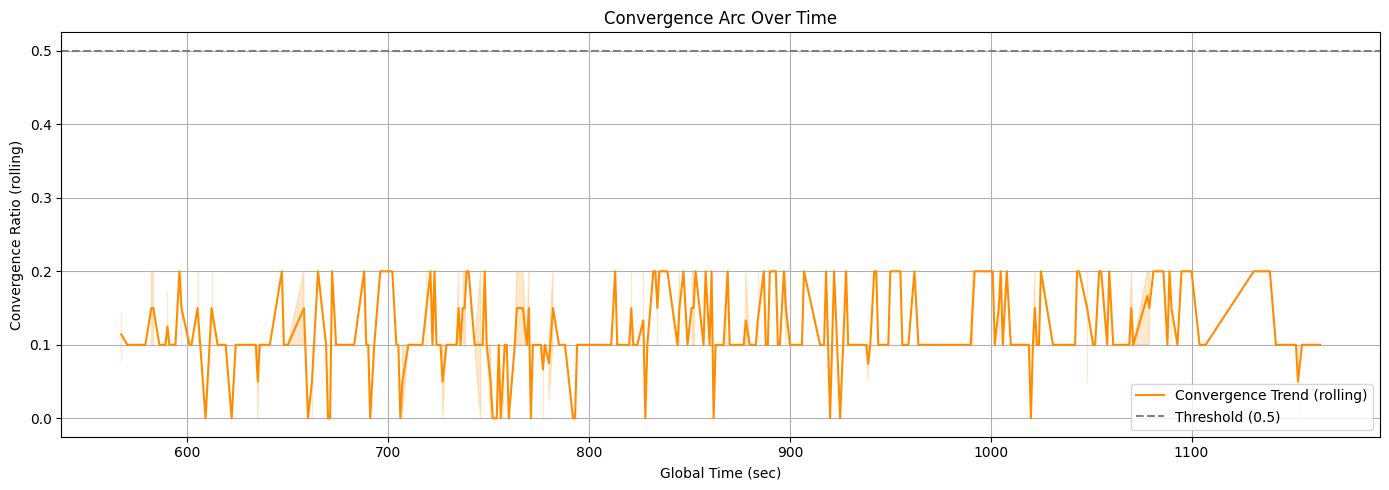

In [18]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Filter a valid session with transcript + timestamp
valid_sessions = df.dropna(subset=['transcript', 'global_timestamp_sec']).groupby('global_session').size()
fallback_session = valid_sessions.idxmax()

df_one = df[df['global_session'] == fallback_session].copy()

# Generate SBERT embeddings
embeddings = model.encode(df_one['transcript'].astype(str).tolist(), convert_to_tensor=True)

# Compute cosine similarity between adjacent utterances
similarities = [1.0]
for i in range(1, len(embeddings)):
    sim = util.cos_sim(embeddings[i], embeddings[i - 1]).item()
    similarities.append(sim)

# Add similarity columns
df_one['similarity'] = similarities
df_one['similarity_smoothed'] = df_one['similarity'].rolling(window=5, min_periods=1).mean()

# Define new ideas based on similarity drop
similarity_diffs = df_one['similarity_smoothed'].diff().fillna(0)
df_one['potential_new_idea'] = similarity_diffs < -0.15

# --- 🔶 Placeholder Convergence Burst Detection ---
# Assume local peaks in smoothed similarity indicate convergence bursts
peaks, _ = find_peaks(df_one['similarity_smoothed'].fillna(0), distance=5)
df_one['in_valid_burst'] = False
df_one.loc[df_one.index[peaks], 'in_valid_burst'] = True

# Fill in other optional columns if missing
for col in ['in_divergence_burst', 'gemini_new_idea']:
    if col not in df_one.columns:
        df_one[col] = False

# --- 📈 Plot 1: Semantic Similarity + New Ideas ---
plt.figure(figsize=(14, 6))
sns.lineplot(
    x=df_one['global_timestamp_sec'],
    y=df_one['similarity_smoothed'],
    label="Smoothed Similarity",
    color='royalblue'
)
sns.scatterplot(
    x=df_one[df_one['potential_new_idea']]['global_timestamp_sec'],
    y=df_one[df_one['potential_new_idea']]['similarity_smoothed'],
    color='red', label='SBERT New Ideas', marker='X'
)
sns.scatterplot(
    x=df_one[df_one['in_valid_burst']]['global_timestamp_sec'],
    y=df_one[df_one['in_valid_burst']]['similarity_smoothed'],
    color='gold', label='Convergence Burst', marker='s'
)
plt.title(f"Semantic Similarity + Idea Dynamics: {fallback_session}")
plt.xlabel("Global Time (sec)")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 📈 Plot 2: Convergence Arc Over Time ---
df_one['running_convergence_ratio'] = df_one['in_valid_burst'].rolling(window=10, min_periods=1).mean()

plt.figure(figsize=(14, 5))
sns.lineplot(
    x=df_one['global_timestamp_sec'],
    y=df_one['running_convergence_ratio'],
    color='darkorange',
    label='Convergence Trend (rolling)'
)
plt.axhline(y=0.5, color='gray', linestyle='--', label='Threshold (0.5)')
plt.title("Convergence Arc Over Time")
plt.xlabel("Global Time (sec)")
plt.ylabel("Convergence Ratio (rolling)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Checking the 950 second mark of a Single Idea

b/c this is much later into the session. 
there's no convergence burst after this moment in the graph.

Again, this is for this session at a conference in particular ... so then the actual solution can still very much vary.



## Tracing Idea Dynamics: Who Introduces and Who Expands?

In [23]:
from sentence_transformers import util
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Parameters
window = 5  # How many utterances after a new idea to consider as follow-up

# Identify potential new idea rows
idea_rows = df_one[df_one['potential_new_idea']].index.tolist()
print(f"🔍 Found {len(idea_rows)} potential new ideas")

idea_expansion_events = []

for idea_idx in idea_rows:
    idea_text = df_one.loc[idea_idx, 'transcript']
    if pd.isna(idea_text) or str(idea_text).strip() == "":
        continue  # skip invalid idea

    try:
        idea_embed = model.encode(idea_text, convert_to_tensor=True)
    except Exception as e:
        print(f"⚠️ Skipping idea at index {idea_idx}: {e}")
        continue

    for offset in range(1, window + 1):
        follow_idx = idea_idx + offset
        if follow_idx >= len(df_one):
            break

        follow_text = df_one.loc[follow_idx, 'transcript']
        if pd.isna(follow_text) or str(follow_text).strip() == "":
            continue  # skip empty follow-up

        try:
            follow_embed = model.encode(follow_text, convert_to_tensor=True)
            similarity = util.cos_sim(idea_embed, follow_embed).item()
        except Exception as e:
            print(f"⚠️ Skipping follow-up at index {follow_idx}: {e}")
            continue

        idea_expansion_events.append({
            'idea_idx': idea_idx,
            'idea_time': df_one.loc[idea_idx, 'global_timestamp_sec'],
            'idea_speaker': df_one.loc[idea_idx, 'speaker'],
            'followup_idx': follow_idx,
            'followup_time': df_one.loc[follow_idx, 'global_timestamp_sec'],
            'followup_speaker': df_one.loc[follow_idx, 'speaker'],
            'semantic_similarity': similarity,
        })

# === Analyze and Plot ===
idea_expansion_df = pd.DataFrame(idea_expansion_events)
print(f"✅ Expansion event rows: {idea_expansion_df.shape[0]}")

if not idea_expansion_df.empty and 'semantic_similarity' in idea_expansion_df.columns:
    high_sim_followups = idea_expansion_df[idea_expansion_df['semantic_similarity'] > 0.6]
    print(f"✅ Strong expansions (similarity > 0.6): {len(high_sim_followups)}")

    if not high_sim_followups.empty:
        print("🔍 Who tends to expand on ideas?")
        print(high_sim_followups.groupby('followup_speaker').size().sort_values(ascending=False))

        print("\n🔍 Who expands on whose ideas?")
        print(high_sim_followups.groupby(['idea_speaker', 'followup_speaker']).size().sort_values(ascending=False))

        plt.figure(figsize=(14, 5))
        sns.scatterplot(
            data=high_sim_followups,
            x='followup_time',
            y='semantic_similarity',
            hue='followup_speaker',
            palette='Dark2',
            s=120,
            edgecolor='black',
            linewidth=0.6,
            alpha=0.9
        )
        plt.title("Idea Expansion Events Over Time")
        plt.xlabel("Global Time (sec)")
        plt.ylabel("Semantic Similarity to Original Idea")
        plt.grid(True)
        plt.legend(title="Expanding Speaker", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("📭 No strong idea expansions (sim > 0.6).")
else:
    print("⚠️ No expansion data or 'semantic_similarity' column missing.")


🔍 Found 7 potential new ideas
✅ Expansion event rows: 0
⚠️ No expansion data or 'semantic_similarity' column missing.


In [24]:
df_one.loc[df_one['potential_new_idea'], ['transcript', 'speaker', 'global_timestamp_sec']].reset_index()

for idx in df_one[df_one['potential_new_idea']].index:
    print(f"\n🧠 New idea @ {idx} | Speaker: {df_one.loc[idx, 'speaker']}")
    print("Idea:", df_one.loc[idx, 'transcript'])

    for i in range(1, 6):
        follow_idx = idx + i
        if follow_idx >= len(df_one):
            break
        print(f"  → Follow-up {i} [{df_one.loc[follow_idx, 'speaker']}]: {df_one.loc[follow_idx, 'transcript']}")



🧠 New idea @ 15619 | Speaker: Linda Detwiler
Idea: Um, I think what we'll do is we'll start with the um I'll put up here I'll share my screen and we'll put the conversation or the um topics, you know, that they suggest or at least for uh starting and then we'll have you take about a minute and write the questions that you think are should be answered in regards to this evolution and coevolution. And then when we come back, I'll have you go around and kind of say who you are and and give a little bit about your background. So I'm going to just share the screen and and put this up real quick.

🧠 New idea @ 15670 | Speaker: Hannah Frank
Idea: I go out, I catch bats, I take their saliva and then I do these PCRs for various infections. Um trying to understand what's out there. And something that I always think about is like I can get, you know, data on the infections, I can get data on, you know, immune parameters and stuff and but like what does that tell us? Like if you have a highly def

So then from here could do the following (likely listed in personal priority):

1. Visual Convergence + Expansion Together 

Overlay convergence arcs + idea expansions in one plot. To see when expansions cluster inside convergence arcs, and who is contributing

2. Speaker Role Analysis

Could do a speaker taxonomy role 
(e.g.: new idea generator, expander, reframer, silent partner, simple counts - also work).
- Because then: some *very* future step would be to track individual people across different sessions / conferences (if they somehow go to multiple conference; but this far is unlikely).

3. Network Graph of Idea -- **this idea doesn't work.**

Visualizing the speakers as nodes - giving semantic interaction network over time.

Remember there's only 4-7 scientists per session.

4. Temporal Distance of Expansion

How long after a new idea do expansions happen? Are they immediate (w/in 5 utterances) or delayed (15+ utterances).
This could also tell about discussion structure.

## (1) When do expansions happen - do they align with convergence?

In [29]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")

# Filter to rows with non-null transcript and timestamp
valid_rows = df[df['transcript'].notna() & df['global_timestamp_sec'].notna()]

# Identify sessions with valid data
valid_sessions = valid_rows['global_session'].value_counts()
print("📋 Valid sessions with non-null transcript + timestamp:\n", valid_sessions)

# Choose a fallback session (first with enough rows)
target_session = valid_sessions.index[0]
df_one = df[df['global_session'] == target_session].copy()

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate SBERT embeddings
embeddings = model.encode(df_one['transcript'].astype(str).tolist(), convert_to_tensor=True)

# Compute similarity to previous utterance
similarities = [1.0]
for i in range(1, len(embeddings)):
    sim = util.cos_sim(embeddings[i], embeddings[i - 1]).item()
    similarities.append(sim)
df_one['similarity'] = similarities
df_one['similarity_smoothed'] = df_one['similarity'].rolling(window=5, min_periods=1).mean()

# Detect potential new ideas
similarity_diffs = df_one['similarity_smoothed'].diff().fillna(0)
df_one['potential_new_idea'] = similarity_diffs < -0.15
print(f"🧠 Found {df_one['potential_new_idea'].sum()} potential new ideas")

# Create expansion events
window = 5
idea_rows = df_one[df_one['potential_new_idea']].index.tolist()
idea_expansion_events = []

for idea_idx in idea_rows:
    idea_text = df_one.loc[idea_idx, 'transcript']
    idea_embed = model.encode(idea_text, convert_to_tensor=True)

    for offset in range(1, window + 1):
        follow_idx = idea_idx + offset
        if follow_idx >= len(df_one):
            break
        follow_text = df_one.loc[follow_idx, 'transcript']
        follow_embed = model.encode(follow_text, convert_to_tensor=True)

        similarity = util.cos_sim(idea_embed, follow_embed).item()

        idea_expansion_events.append({
            'idea_idx': idea_idx,
            'idea_time': df_one.loc[idea_idx, 'global_timestamp_sec'],
            'idea_speaker': df_one.loc[idea_idx, 'speaker'],
            'followup_idx': follow_idx,
            'followup_time': df_one.loc[follow_idx, 'global_timestamp_sec'],
            'followup_speaker': df_one.loc[follow_idx, 'speaker'],
            'semantic_similarity': similarity,
        })

# Convert to DataFrame
idea_expansion_df = pd.DataFrame(idea_expansion_events)
print(f"✅ Expansion event rows: {idea_expansion_df.shape[0]}")

# Filter for strong expansions
if 'semantic_similarity' in idea_expansion_df.columns:
    high_sim_followups = idea_expansion_df[idea_expansion_df['semantic_similarity'] > 0.6]
    print(f"✅ Strong expansions (similarity > 0.6): {len(high_sim_followups)}")
else:
    high_sim_followups = pd.DataFrame()
    print("⚠️ 'semantic_similarity' column not found in expansion DataFrame.")

# Visualization (only if data exists)
if not high_sim_followups.empty:
    plt.figure(figsize=(14, 5))
    sns.scatterplot(
        data=high_sim_followups,
        x='followup_time',
        y='semantic_similarity',
        hue='followup_speaker',
        palette='Dark2',
        s=120,
        edgecolor='black',
        linewidth=0.6,
        alpha=0.9
    )
    plt.axhline(y=0.6, color='gray', linestyle='--', label='Similarity Threshold')
    plt.title(f"Idea Expansion Events: {target_session}")
    plt.xlabel("Global Time (sec)")
    plt.ylabel("Semantic Similarity to Original Idea")
    plt.grid(True)
    plt.legend(title="Expanding Speaker", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No high_sim_followups data available. Skipping plot.")


📋 Valid sessions with non-null transcript + timestamp:
 global_session
2021_09_30_MZT_S7_MZT    425
2021_05_20_ABI_S8_ABI    326
2021_06_10_SLU_S4_SLU    305
2021_05_21_ABI_S5_ABI    298
2021_05_21_ABI_S6_ABI    288
                        ... 
2021_09_30_MZT_S6_MZT     39
2021_04_23_MND_S9_MND     37
2021_04_22_MND_S8_MND     31
2021_04_23_MND_S4_MND     14
2021_04_22_MND_S2_MND      1
Name: count, Length: 82, dtype: int64


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


🧠 Found 7 potential new ideas
✅ Expansion event rows: 0
⚠️ 'semantic_similarity' column not found in expansion DataFrame.
⚠️ No high_sim_followups data available. Skipping plot.


## visual convergence + expansion

In [25]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Recompute embeddings
embeddings = model.encode(df['transcript'].tolist(), convert_to_tensor=True)

# Compute cosine similarity between consecutive utterances
similarities = [util.cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]
df['cosine_similarity_to_next'] = similarities + [np.nan]

# ---- ADDITIONAL PROCESSING FOR CONVERGENCE + EXPANSION ---- #

# (1) Flag expansions based on Gemini annotations
# Assuming has_new_idea and has_explanation columns exist (bool or 0/1)
df['is_expansion'] = df['has_new_idea'].fillna(False) | df['has_explanation'].fillna(False)

# (2) Flag convergence arcs using cosine similarity threshold
CONVERGENCE_THRESHOLD = 0.6  # tweakable
df['is_converging'] = df['cosine_similarity_to_next'] > CONVERGENCE_THRESHOLD

# Optional: Confirm counts
print(f"Total utterances: {len(df)}")
print(f"Expansions flagged: {df['is_expansion'].sum()}")
print(f"Convergence arcs flagged: {df['is_converging'].sum()}")



Total utterances: 16414
Expansions flagged: 3804
Convergence arcs flagged: 1253


For this session + conference in particular (2021_09_30_MZT_S7):

~23% of utternaces are expansions
~7.6% of utterances mark convergence arcs.

## (2) Speaker Role Analysis

                speaker  total_utterances  new_ideas  expansions  idea_ratio  \
320    Lisa Kaltenegger               257         29          23    0.112840   
72           Brad Smith               220         16          16    0.072727   
75          Brian Pogue               206          8          19    0.038835   
384      Niki Parenteau               193          2          19    0.010363   
131    Dimitar Sasselov               191         11          24    0.057592   
..                  ...               ...        ...         ...         ...   
174            Haike Qi                 1          0           0    0.000000   
394            Paul Hsu                 1          0           0    0.000000   
186                 Jae                 1          0           0    0.000000   
192        Jamie Bender                 1          0           0    0.000000   
369  Michael D Cullinan                 1          0           0    0.000000   

     expansion_ratio   role  
320      

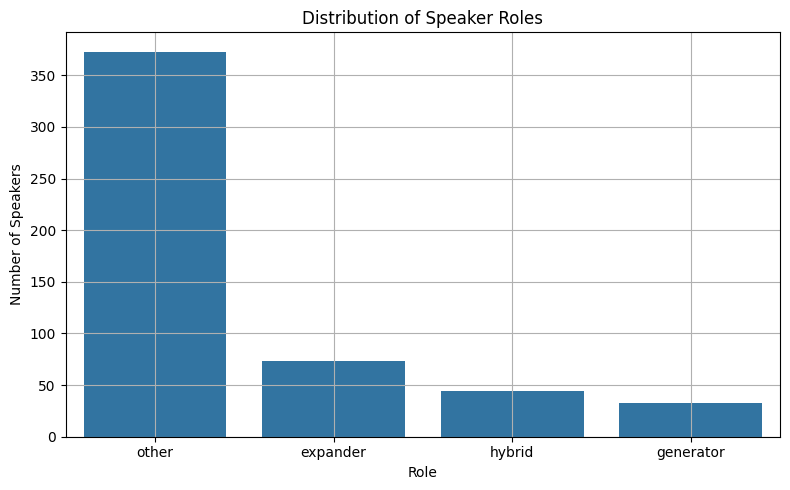

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Count speaker stats ---
speaker_stats = df.groupby('speaker').agg(
    total_utterances=('transcript', 'count'),
    new_ideas=('has_new_idea', 'sum'),
    expansions=('has_explanation', 'sum')
).reset_index()

# --- Add ratio columns ---
speaker_stats['idea_ratio'] = speaker_stats['new_ideas'] / speaker_stats['total_utterances']
speaker_stats['expansion_ratio'] = speaker_stats['expansions'] / speaker_stats['total_utterances']

# --- Classify speaker roles ---
def classify_role(row):
    if row['idea_ratio'] > 0.3 and row['expansion_ratio'] < 0.2:
        return "generator"
    elif row['expansion_ratio'] > 0.3 and row['idea_ratio'] < 0.2:
        return "expander"
    elif row['idea_ratio'] > 0.2 and row['expansion_ratio'] > 0.2:
        return "hybrid"
    else:
        return "other"

speaker_stats['role'] = speaker_stats.apply(classify_role, axis=1)

# --- Optional: view the speaker summary table ---
print(speaker_stats.sort_values(by='total_utterances', ascending=False))

# --- Now plot role distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(data=speaker_stats, x='role', order=speaker_stats['role'].value_counts().index)
plt.title("Distribution of Speaker Roles")
plt.xlabel("Role")
plt.ylabel("Number of Speakers")
plt.grid(True)
plt.tight_layout()
plt.show()


But with all of this:

- I am able to figure out the points of convergences (and by contrast, divergences).


BUT ---- THIS IS STILL THE ISSUE THAT I AM HAVING AT THIS POINT IN THE IPYNB

- do these "major points of convergences" actually lead to a point of solution. 

Take note that - in fact - not all convergences are created equal.

- AND, can this be backed by the transcript (or something similar - would multiple metrics have to be use.)?



So, given all this - at this point in the ipynb:

Should I send my notebook to Evey with all of the progress.

OR

I can look up another piece of literature on "How do we know if convergence leads to a meaningful outcome or solution?"

**I can try searching up these paper topics:**

"Decision-making in team science meetings"

"Language markers of scientific insight"

"Convergence and knowledge creation in collaborative work"

"Discourse patterns in consensus-building"

"Linguistic indicators of innovation in teams"

Convergence can happen *before* and *after* collaborative learning sessions.

B/c the different types of convergence is:

1. Stated convergence

2. Inferred convergence

(more information in the Google Docs)

## Burst-Level Speaker and Role Analysis

In [39]:
# --- Step 1: Compute speaker roles and merge into df_one ---

# Speaker stats from df_one
speaker_stats = df_one.groupby('speaker').agg(
    total_utterances=('transcript', 'count'),
    new_ideas=('has_new_idea', 'sum'),
    expansions=('has_explanation', 'sum')
).reset_index()

# Add ratios
speaker_stats['idea_ratio'] = speaker_stats['new_ideas'] / speaker_stats['total_utterances']
speaker_stats['expansion_ratio'] = speaker_stats['expansions'] / speaker_stats['total_utterances']

# Define roles
def classify_role(row):
    if row['idea_ratio'] > 0.3 and row['expansion_ratio'] < 0.2:
        return "generator"
    elif row['expansion_ratio'] > 0.3 and row['idea_ratio'] < 0.2:
        return "expander"
    elif row['idea_ratio'] > 0.2 and row['expansion_ratio'] > 0.2:
        return "hybrid"
    else:
        return "other"

speaker_stats['role'] = speaker_stats.apply(classify_role, axis=1)

# Merge back into df_one
df_one = df_one.merge(speaker_stats[['speaker', 'role']], on='speaker', how='left')


# --- Step 2: Build convergence burst summary table ---

burst_summaries = []
for idx, (start, end) in enumerate(convergence_bursts):
    burst_df = df_one[
        (df_one['global_timestamp_sec'] >= start) &
        (df_one['global_timestamp_sec'] <= end)
    ]
    
    role_counts = burst_df['role'].value_counts().to_dict()
    speaker_counts = burst_df['speaker'].value_counts().to_dict()
    new_ideas = burst_df.get('has_new_idea', pd.Series(dtype=int)).sum()
    explanations = burst_df.get('has_explanation', pd.Series(dtype=int)).sum()
    unique_speakers = burst_df['speaker'].nunique()

    burst_summaries.append({
        'burst_id': idx,
        'start_sec': start,
        'end_sec': end,
        'duration_sec': end - start,
        'utterance_count': len(burst_df),
        'speaker_count': unique_speakers,
        'top_speaker': burst_df['speaker'].mode().iloc[0] if not burst_df.empty else None,
        'dominant_role': burst_df['role'].mode().iloc[0] if not burst_df.empty else None,
        'role_counts': role_counts,
        'speaker_counts': speaker_counts,
        'new_idea_count': new_ideas,
        'explanation_count': explanations,
        'is_inter_speaker': unique_speakers > 1
    })

burst_df = pd.DataFrame(burst_summaries)
burst_df.to_csv("convergence_burst_summary.csv", index=False)
burst_df.head()


,burst_id,start_sec,end_sec,duration_sec,utterance_count,speaker_count,top_speaker,dominant_role,role_counts,speaker_counts,new_idea_count,explanation_count,is_inter_speaker
0,0,660.0,670.0,10.0,7,5,Linda Detwiler,other,"{'other': 5, 'expander': 1, 'hybrid': 1}","{'Linda Detwiler': 3, 'Richard Wiener': 1, 'Ma...",0,2,True
1,1,960.0,970.0,10.0,3,2,Linda Detwiler,other,{'other': 3},"{'Linda Detwiler': 2, 'adela': 1}",0,0,True
2,2,1067.0,1077.0,10.0,8,6,Gonzalo Vazquez Prokopec,other,"{'other': 7, 'generator': 1}","{'Linda Detwiler': 2, 'Gonzalo Vazquez Prokope...",0,0,True
3,3,636.0,646.0,10.0,6,6,Cheryl Andam,other,"{'other': 5, 'hybrid': 1}","{'Lauren Charles': 1, 'Liliana Salvador': 1, '...",0,0,True
4,4,724.0,734.0,10.0,12,8,Linda Detwiler,other,"{'other': 11, 'expander': 1}","{'Linda Detwiler': 4, 'Lauren Charles': 2, 'Ta...",1,1,True
